In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import pickle

In [ ]:
!pip install pyarrow

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')

In [8]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


In [9]:
# Originally wanted only dispatch type but this trip-type resulted in a lot of data that were less than one minute
# df = df[df.trip_type == 2] # filters out all data for only dispatch trip types (which is trip_type = 2)

In [3]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [4]:
df['duration'] = df['duration']/pd.Timedelta(minutes=1)

[]

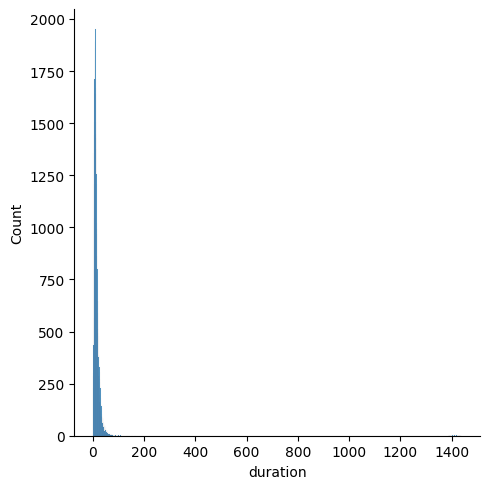

In [5]:
sns.displot(df.duration)
plt.plot()
# The distribution has a very long tail, so we cannot see the distribution well.

In [6]:
# Used describe to better understand the statistics/distribution
df.duration.describe()

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
25%          7.250000
50%         11.400000
75%         17.316667
max       1438.983333
Name: duration, dtype: float64

In [7]:
# These trip times look suspicious. To get a closer look, we specify some percentiles to look at
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    56551.000000
mean        18.171379
std         75.464751
min          0.000000
50%         11.400000
95%         33.683333
98%         46.816667
99%         59.825000
max       1438.983333
Name: duration, dtype: float64

In [8]:
# These trip times look suspicious. To get a closer look, we specify some percentiles to look at
df.duration.describe(percentiles=[0.95, 0.98, 0.99])
# From business perspective, we only want to look at rides one hour or less. 
# Filtering out all rides over an hour or less than one minute
df = df[(df.duration <= 60.0) & (df.duration >= 1.0)]
print(df.duration.describe())

count    54373.000000
mean        13.778175
std          9.021503
min          1.000000
25%          7.583333
50%         11.566667
75%         17.300000
max         60.000000
Name: duration, dtype: float64


In [9]:
# We need to think about what categorical and what numerical variables we will use
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical].dtypes # Understanding the data types for the categorical

PULocationID    int32
DOLocationID    int32
dtype: object

In [10]:
# Change data types for categorical since it is currently integers
df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical + numerical].to_dict(orient='records') # turns each row into a dictionary
# Now we vectorize our dictionaries, bc we want to create one hot encoding using dictvectorizer
dv = DictVectorizer() # create object (instance) of DictVectorizer

In [11]:
# Now, we create our feature matrix (X_train) and our target matrix (Y_train).
X_train = dv.fit_transform(train_dicts) # create our feature matrix for training
print(X_train)
Y_train = df['duration'].values # The Y values are just the duration values. These are our target values.
print(Y_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 163119 stored elements and shape (54373, 449)>
  Coords	Values
  (0, 139)	1.0
  (0, 357)	1.0
  (0, 448)	1.98
  (1, 70)	1.0
  (1, 416)	1.0
  (1, 448)	6.54
  (2, 163)	1.0
  (2, 425)	1.0
  (2, 448)	3.08
  (3, 12)	1.0
  (3, 425)	1.0
  (3, 448)	2.4
  (4, 144)	1.0
  (4, 425)	1.0
  (4, 448)	5.14
  (5, 106)	1.0
  (5, 389)	1.0
  (5, 448)	2.0
  (6, 138)	1.0
  (6, 425)	1.0
  (6, 448)	3.2
  (7, 139)	1.0
  (7, 293)	1.0
  (7, 448)	2.01
  (8, 125)	1.0
  :	:
  (54364, 448)	1.6
  (54365, 51)	1.0
  (54365, 293)	1.0
  (54365, 448)	1.09
  (54366, 45)	1.0
  (54366, 318)	1.0
  (54366, 448)	1.52
  (54367, 137)	1.0
  (54367, 397)	1.0
  (54367, 448)	2.75
  (54368, 150)	1.0
  (54368, 389)	1.0
  (54368, 448)	0.0
  (54369, 213)	1.0
  (54369, 423)	1.0
  (54369, 448)	0.49
  (54370, 213)	1.0
  (54370, 423)	1.0
  (54370, 448)	0.52
  (54371, 183)	1.0
  (54371, 397)	1.0
  (54371, 448)	1.17
  (54372, 233)	1.0
  (54372, 389)	1.0
  (54372, 448)	9.27
[11.5      

In [12]:
dv.feature_names_ # feature names the vectorizer uses. Each feature is one hot encoded.

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=11',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',

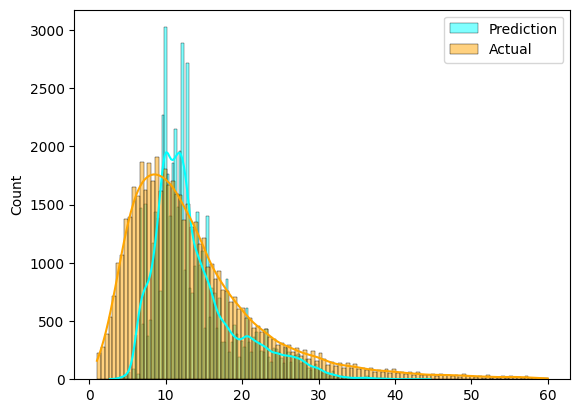

In [13]:
# Now we train a model (linear regression model)
lr = LinearRegression()
lr.fit(X_train, Y_train)
# Now that we fitted the data to our model, we will apply the model onto our training dataset (just to see its current performance)
# (We will use the February dataset as the validation dataset later)
Y_pred = lr.predict(X_train)
# These functions are figure-level functions so they will create separate figures.
# sns.displot(Y_pred, label='prediction')
# sns.displot(Y_train, label='training')
# To create overlaid plots in the same figure, we need an axes-level figure:
sns.histplot(Y_pred, color="cyan", label="Prediction", kde=True) # kde = kernel density estimation. This curve estimates the distribution
sns.histplot(Y_train, color="orange", label="Actual", kde=True)
# KDE is a non-parametric way to estimate the probability density function (PDF) of a continuous variable. 
# In simpler terms, it gives you a smooth curve that represents the distribution of your data.
plt.legend()

In [14]:
# Estimate the score, we use RMSE
rmse = root_mean_squared_error(Y_train, Y_pred)
print(rmse) # 7 min, therefore our model is wrong on average by 7 min.

7.1228220948023795


In [15]:
# Now, we want to see the results on the validation dataset

df_val = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')
df_val['duration'] = df_val.lpep_dropoff_datetime - df_val.lpep_pickup_datetime
df_val['duration'] = df_val['duration']/pd.Timedelta(minutes=1)
df_val = df_val[(df_val.duration <= 60.0) & (df_val.duration >= 1.0)]
df_val[categorical] = df_val[categorical].astype(str)

len(df), len(df_val) # we want to see the split
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
Y_val = df_val['duration'].values

Y_pred_val = lr.predict(X_val)
rmse_val = root_mean_squared_error(Y_val, Y_pred_val)
print(rmse_val) # Trying the model on the validation got us 7.3 min, slightly worse. This is our baseline since we want to predict validation, not training dataset.

7.265831283470444


In [16]:
# Now, we try Lasso to see if this improves the results
lr = Lasso()
lr.fit(X_train, Y_train)
Y_pred_lass = lr.predict(X_val)
root_mean_squared_error(Y_val, Y_pred_lass) # Our error is even worse, so we need to tweak the lasso model a bit.

9.110340896856446

In [17]:
# Since Lasso did not improve the error, we will try ridge
rid = Ridge()
rid.fit(X_train, Y_train)
Y_pred_lass = rid.predict(X_val)
root_mean_squared_error(Y_val, Y_pred_lass) # Our error is even worse, so we need to tweak the lasso model a bit.

7.263147327402421

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out) #  pickle.dump(what we are saving), where we are saving it to)

# Notes:
- Tracking experiments: can make a notes cell to track outputs from experiments or track in a spreadsheet. A better way is to use log. (log to experiment tracker).
- Saving models: instead of saving the model using pickle (we don't know which lr was last run, we don't know the performance of the model, we might not remember which linear regression model we used since name is just lin_reg). INSTEAD, we should save to model registry.
- Experiment tracker + model registry allows for models with performance to be saved so no ambiguity.
- MLFlow is used for these purposes.
- ML Pipelines: best practices/tools so we don't need to worry about which cells need to be run and in what order and what does not need to be run (Prefect and Kubeflow are tools for ML pipelines).

# Notes: MLOps Maturity Levels (Microsoft definition)
- MLOps maturity levels (0-4): At the highest maturity level, fully automated. The system can retrain the model by itself when performance drops.
- 0: No MLOps: Jupyter notebooks, no proper experimental methods, no metadata, no pipelines, no automation
- 1: DevOps, no MLOps. Some automation, releases automated. unit and integration tests, CI/CD, Operational metrics (requests/sec, network situation, etc.). No experiment tracking, no reproducibility, DS separated from engineers.
- 2: Automated Training: Training Pipeline (parametrized pipelines), Experiment tracking, Model registry (know which models are in production and which are not), low friction deployment (easy but not necessarily automated), DS work with engineers
- 3: Automated deployment: Easy to deploy model (either automated or low friction), have ML platform (place for hosting models) - can deploy model with simple API call, run A/B tests, model monitoring
- 4: Full MLOps Automation - automatic training, automatic retraining, automatic deployment.